## DATABOOTCAMP PROJECT : CREDIT RISK MODELLING

#### WHAT IS CREDIT RISK AND WHY IS IT IMPORTANT?
When giving a loan a creditor,also known as lender provides goods and services to a debtor who can be referred to as borrowers based on the trust that borrower will repay the lender. when someone fails to repay a loan,it is said to be default.The possiblity that someone who has borrowed money will default is known as Credit Risk.

Lenders inability or failure to  estimate borrowers probablity of default can have grave consequences for lenders and society.In general lending to borrowers with a high probability of default is one of the main reasons for serious financial crisis such as the global financial crisis in 2008.It was the most serious financial crisis since the times of the Great Depression in the 1930s.The main factor that led to the 2008 financial crisis was high default rates of subprime home mortgages. Many big banks like Lehmam Brothers and Bear Stearns went bakrupt.Therefore that's one example why credit risk is one of the most important variables in the financialsystem of today.
#### Project Focus
It is important is to be able to estimate credit risk of each borrower as precisely as possible.Hence, or project focuses on creating three different models a PD or probability of default model showing the probability of a customer not repaying their debt and LGD or loss givendefault model showing the proportion of an exposure a company loses when a customer defaults and an
EAD or exposure at default model showing the total loss in terms of amount of money the bank is exposed to if a customer defaults.Using this information we'll create a score card.The score cards are identical to the ones bank officers use on a daily basis to accept or reject loan applications.Finally we'll combine these three models to calculate the total expected loss for the whole portfolio of loans that the bank holds the expected loss or E.L.

#### Downloading Packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### Importing Data into dataframe 
The dataset contains all available data for more than 800000 consumer loans issued from 2007 to 2015 by lending club a large U.S. peer to peer lending company. we have downloaded data from kaggle https://www.kaggle.com/wendykan/lending-club-loan-data

In [ ]:
loan = pd.read_csv(r"loan_data_2007_2014.csv")


In [ ]:
loan.head()

### GENERAL DATA PREPARATION(CLEANING/SHAPING/FORMATTING)

In [ ]:
#First lets get the information about data
#loan.info()

#### From the above loan info we can see that there are few object variable that we need as numeric like emp_length,term. Hence we change them to numeric

In [ ]:
loan['emp_length'].unique()

In [ ]:
# Removing years from emp_lenght
loan['emp_length'] = loan['emp_length'].str.replace('\+ years', '')
loan['emp_length'] = loan['emp_length'].str.replace('< 1 year', str(0))
loan['emp_length'] = loan['emp_length'].str.replace('n/a',  str(0))
loan['emp_length'] = loan['emp_length'].str.replace(' years', '')
loan['emp_length'] = loan['emp_length'].str.replace(' year', '')

In [ ]:
#changing emp_length to numeric
loan['emp_length'] = pd.to_numeric(loan['emp_length'])

In [ ]:
# simlilarly changing term variable to numeric
loan['term'].unique()


In [ ]:
loan['term'] = loan['term'].str.replace('months','')


In [ ]:
loan['term'] = pd.to_numeric(loan['term'])
loan['term'].head()

#### Now changing few attributes like 'earliest_cr_line' and 'issue_d' to datetime datatype

In [ ]:
loan['earliest_cr_line'].head()

In [ ]:
##Converting to datetime format
loan['earliest_cr_line'] = pd.to_datetime(loan['earliest_cr_line'], format = '%b-%y')
loan['earliest_cr_line'].head()

In [ ]:
## We take the reference date and calulate the time since earliest credit line has passed in months
loan['month_diff_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan['earliest_cr_line']) / np.timedelta64(1, 'M')))

In [ ]:
# Dates from 1969 and before are not being converted well,they have become 2069 and similar
loan['month_diff_earliest_cr_line'].describe()


In [ ]:
#There are 1169 such strange value.
loan.loc[loan['month_diff_earliest_cr_line'] < 0].count()
# Hence,we set the rows that had negative differences to the maximum value.
loan['month_diff_earliest_cr_line'][loan['month_diff_earliest_cr_line'] < 0] = loan['month_diff_earliest_cr_line'].max()


In [ ]:
loan['issue_d']
##Converting to datetime format
loan['issue_d'] = pd.to_datetime(loan['issue_d'], format = '%b-%y')
#### We take the reference date and calulate the time since earliest credit line has passed in months
loan['month_diff_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan['issue_d']) / np.timedelta64(1, 'M')))
loan['month_diff_issue_d'][loan['month_diff_issue_d'] < 0] = loan['month_diff_issue_d'].max()

#### Next, we will perform One hot encoding by creating dummy variables for categorial variables

In [ ]:
loan_dummies= [pd.get_dummies(loan['grade'], prefix = 'grade', prefix_sep = ':'),
               pd.get_dummies(loan['sub_grade'], prefix = 'sub_grade', prefix_sep = ':'),
               pd.get_dummies(loan['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
               pd.get_dummies(loan['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
               pd.get_dummies(loan['loan_status'], prefix = 'loan_status', prefix_sep = ':'),
               pd.get_dummies(loan['purpose'], prefix = 'purpose', prefix_sep = ':'),
               pd.get_dummies(loan['addr_state'], prefix = 'addr_state', prefix_sep = ':'),
               pd.get_dummies(loan['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':')]
loan_dummies = pd.concat(loan_dummies, axis = 1)
loan= pd.concat([loan, loan_dummies], axis = 1)


In [ ]:
#list(loan)

#### Checking for missing values and cleaning them

Total revolving high credit/ credit limit', is where one can access money until he/she has  borrowed up to the maximum amount,also known as your credit limit, so it makes sense that the missing values are equal to funded_amnt.

In [ ]:
loan.isnull().sum()
loan['total_rev_hi_lim'].fillna(loan['funded_amnt'], inplace=True)

In [ ]:
## Simililary we clean other attributes having missing values
loan['annual_inc'].fillna(loan['annual_inc'].mean(), inplace=True)
loan['month_diff_earliest_cr_line'].fillna(0, inplace=True)
loan['acc_now_delinq'].fillna(0, inplace=True)
loan['total_acc'].fillna(0, inplace=True)
loan['pub_rec'].fillna(0, inplace=True)
loan['open_acc'].fillna(0, inplace=True)
loan['inq_last_6mths'].fillna(0, inplace=True)
loan['delinq_2yrs'].fillna(0, inplace=True)
loan['emp_length'].fillna(0, inplace=True)

## PD MODEL
### DATA PREPARATION
#### DEPENDENT VARIABLES,     GOOD/BAD LOAN DEFINITION

Dependent variable is what we are going to predict.We are interested in the borrowers and the respective loans on which they have defaulted or not.Loans that have defaulted will be called bad while those which did not are good loans. Therefore, its imperative for us to decribe what default is.

we will create a new variable in the data set of a boolean or binary type.Zero will stand for default or bad loan while one for a good loan.

In [ ]:
loan['loan_status'].unique()

In [ ]:
bad_loans = ['Charged Off', 'Default','Does not meet the credit policy. Status:Charged Off','Late (31-120 days)']
loan['good_bad'] = np.where(loan['loan_status'].isin(bad_loans), 0, 1)

Established methodology to model probablity of default is logistic regression. Logistic Regression estimates the relationship between two things.The logarithm of odds of an outcome of interest or dependent variable and a linear combination of predictors
or independent variables.

The model must be very easy to understand and apply.Even people who have never heard of statistical analysis should be able to work with it.This is why the established practice is for all independent variables in the probability of default models to be dummy variables that is binary categorical variables or indicator variables.

#### Approach for constructing Independent Variable
Fine classing :- we will use fine classing method for turning continous variables into categories by bundling them up by there properties   
Weight of Evidence :- To what extent an independent variable would predict a dependent variable  
                       WOE = ln(% non default events/% default events)    
Coarse classing :- We will bundle variables that have similar weight of evidence.  

### Splitting Data

In [ ]:
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(loan.drop('good_bad', axis = 1), loan[['good_bad']], test_size = 0.2, random_state = 50)

In [ ]:
# df_inputs_prepr = loan_data_inputs_test
# df_targets_prepr = loan_data_targets_test

df_inputs_prepr = loan_data_inputs_train
df_targets_prepr = loan_data_targets_train

In [ ]:
## To define WOE and Information value

In [ ]:
def woe_and_IV(df,column_name, good_bad_variable_df):
    df = pd.concat([df[column_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    #df['diff_prop_good'] = df['prop_good'].diff().abs()
    #df['diff_WoE'] = df['WoE'].diff().abs()
    #df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    #df['IV'] = df['IV'].sum()
    return df

In [ ]:
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'b')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

In [ ]:
# Here we are going to calculate weight of evidence
df_temp = woe_and_IV(df_inputs_prepr, 'grade', df_targets_prepr)
df_temp.set_index('grade')

## VISUALISING RESULT THE RESULT

In [ ]:
# reference category : grade:G
ax = df_temp.plot(x = 'grade',y='WoE',figsize=(18,6),lw=5)
ax.set_title('Weight of evidence of grade')
ax.set_ylabel('Weight of evidence')

#### From above observation we can conclude that individuals in Grade:G are bad borrowers
Based on weight of evidence we must decide how to organize the catogaries of discrete variables into dummy variables. we will take reference category having the highest default rate

#### Home_Ownership :-Visualising

In [ ]:
## Calculating weight of evidence and plotting
df_temp = woe_and_IV(df_inputs_prepr, 'home_ownership', df_targets_prepr)
df_temp.set_index('home_ownership')
ax = df_temp.plot(x = 'home_ownership',y='WoE',figsize=(18,6),lw=5)
ax.set_title('Weight of evidence of home_ownership')
ax.set_ylabel('Weight of evidence')

#### Coarse classing the home_ownership according to Weight of Evidence
Rent,None,other has high default rate hence we keep them as reference category and combine them in one category
We have three category 'home_ownership:RENT_OTHER_NONE' , home_ownership:Own, home_ownership:Mortage

In [ ]:
# reference category 'home_ownership:RENT_OTHER_NONE' ,
#other categories'home_ownership:OWN','home_ownership:MORTGAGE'
df_inputs_prepr['home_ownership:RENT_OTHER_NONE'] = sum([df_inputs_prepr['home_ownership:RENT'], df_inputs_prepr['home_ownership:OTHER'],
                                                      df_inputs_prepr['home_ownership:NONE']])

#### Addr_state :- Visualising


In [ ]:
df_temp = woe_and_IV(df_inputs_prepr, 'addr_state', df_targets_prepr)
df_temp


Now we can see here that there are two states Nebraska and Iowa with a considerably lower weight of evidence compared to most states.There are also two states with a considerably higher weight of evidence Maine and Idaho.Note that weight of evidence for the last state could not be calculated because there are no bad borrowers.Besides it is highly likely that the low number of observations is the reason for their extreme weight of evidence values so we'll include these states in the first the worst and the last the best category

In [ ]:
plot_by_woe(df_temp)


Now lets focus on other 46 states: because of the outliers we believed that rest of the state have same weight of evidence .
from  below we will categorise ND,NE,IA,NV,FL,HI,AL together and ME,ID,DC together

In [ ]:
plot_by_woe(df_temp.iloc[2: -2, : ])

In [ ]:
plot_by_woe(df_temp.iloc[4: -3, : ])

In [ ]:
#reference category
df_inputs_prepr['addr_state:NE_IA_NV_FL_HI_AL'] = sum([df_inputs_prepr['addr_state:NE'],
                                              df_inputs_prepr['addr_state:IA'], df_inputs_prepr['addr_state:NV'],
                                              df_inputs_prepr['addr_state:FL'], df_inputs_prepr['addr_state:HI'],
                                                          df_inputs_prepr['addr_state:AL']])
df_inputs_prepr['addr_state:NY_MO_MD_NJ_CA_LA_RI_VA'] = sum([df_inputs_prepr['addr_state:NY'], df_inputs_prepr['addr_state:MO'],
                                              df_inputs_prepr['addr_state:MD'], df_inputs_prepr['addr_state:NJ'],
                                              df_inputs_prepr['addr_state:CA'], df_inputs_prepr['addr_state:LA'],
                                                          df_inputs_prepr['addr_state:RI'],df_inputs_prepr['addr_state:VA']])
df_inputs_prepr['addr_state:UT_NC_AR_AZ_PA_DE_TN_OH_SD'] = sum([df_inputs_prepr['addr_state:UT'], df_inputs_prepr['addr_state:NC'],
                                              df_inputs_prepr['addr_state:AR'], df_inputs_prepr['addr_state:AZ'],
                                              df_inputs_prepr['addr_state:PA'], df_inputs_prepr['addr_state:DE'],
                                              df_inputs_prepr['addr_state:TN'],df_inputs_prepr['addr_state:OH'],
                                              df_inputs_prepr['addr_state:SD']])
df_inputs_prepr['addr_state:MI_IN_MN_KY_WI_MA_GA_WA_OR'] = sum([df_inputs_prepr['addr_state:MI'], df_inputs_prepr['addr_state:IN'],
                                              df_inputs_prepr['addr_state:MN'], df_inputs_prepr['addr_state:KY'],
                                              df_inputs_prepr['addr_state:WI'], df_inputs_prepr['addr_state:MA'],
                                              df_inputs_prepr['addr_state:GA'],df_inputs_prepr['addr_state:WA'],
                                              df_inputs_prepr['addr_state:OR']])
df_inputs_prepr['addr_state:SC_VT_KS_IL_CO_MT_CT_AK_WV'] = sum([df_inputs_prepr['addr_state:SC'], df_inputs_prepr['addr_state:VT'],
                                              df_inputs_prepr['addr_state:KS'], df_inputs_prepr['addr_state:IL'],
                                              df_inputs_prepr['addr_state:CO'], df_inputs_prepr['addr_state:MT'],
                                              df_inputs_prepr['addr_state:CT'],df_inputs_prepr['addr_state:AK'],
                                              df_inputs_prepr['addr_state:WV']])
df_inputs_prepr['addr_state:ME_ID_DC'] = sum([df_inputs_prepr['addr_state:ME'], df_inputs_prepr['addr_state:ID'],
                                              df_inputs_prepr['addr_state:DC']])
df_inputs_prepr['addr_state:MS_WY_NH'] = sum([df_inputs_prepr['addr_state:MS'], df_inputs_prepr['addr_state:WY'],
                                              df_inputs_prepr['addr_state:NH']])
# We will leave TX as separate category


#### Verification status : Visualisation

In [ ]:
df_temp = woe_and_IV(df_inputs_prepr, 'verification_status', df_targets_prepr)
df_temp

In [ ]:
plot_by_woe(df_temp)

#### Purpose : Visualization

In [ ]:
df_temp = woe_and_IV(df_inputs_prepr, 'purpose', df_targets_prepr)
df_temp

In [ ]:
plot_by_woe(df_temp,90)

From above, we leave 'debt_consolidtion' in a separate category because of high number of observations .Also, 'purpose:educ_small_other_moving_ren_house': since they are approximately just 5% of total observations and also has low WOE.

In [ ]:
# reference category 'purpose:educ_small_other_moving_ren_house'
df_inputs_prepr['purpose:educ_small_other_moving_ren_house'] = sum([df_inputs_prepr['purpose:house'],df_inputs_prepr['purpose:educational'],df_inputs_prepr['purpose:small_business'], 
                                                               df_inputs_prepr['purpose:renewable_energy'],df_inputs_prepr['purpose:other']])
df_inputs_prepr['purpose:med_wedding_vac_wed'] = sum([df_inputs_prepr['purpose:medical'],df_inputs_prepr['purpose:wedding'],df_inputs_prepr['purpose:vacation']])
df_inputs_prepr['purpose:home_major_car_credit'] = sum([df_inputs_prepr['purpose:major_purchase'], df_inputs_prepr['purpose:home_improvement']
                                                        ,df_inputs_prepr['purpose:car'],df_inputs_prepr['purpose:credit_card']])

#### Preprocessing Continous Variable

In [ ]:
# WoE function for ordered discrete and continuous variables
def woe_ordered_continuous(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df['diff_prop_good'] = df['prop_good'].diff().abs()
    #df['diff_WoE'] = df['WoE'].diff().abs()
    #df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    #df['IV'] = df['IV'].sum()
    return df

#### Term : Visualization

In [ ]:
# term
df_inputs_prepr['term'].unique()

In [ ]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'term', df_targets_prepr)
df_temp

In [ ]:
plot_by_woe(df_temp)

#### Emp_length : Visualization

In [ ]:
#term:60 is reference ategory
df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term'] == 36), 1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term'] == 60), 1, 0)

In [ ]:
df_inputs_prepr['emp_length'].unique()

In [ ]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'emp_length', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp)

In [ ]:
# We create the following categories: '0', '1', '2 - 4', '5 - 6', '7 - 9', '10'
# '0' will be the reference category
df_inputs_prepr['emp_length:0'] = np.where(df_inputs_prepr['emp_length'].isin([0]), 1, 0)
df_inputs_prepr['emp_length:1'] = np.where(df_inputs_prepr['emp_length'].isin([1]), 1, 0)
df_inputs_prepr['emp_length:2-4'] = np.where(df_inputs_prepr['emp_length'].isin(range(2, 5)), 1, 0)
df_inputs_prepr['emp_length:5-6'] = np.where(df_inputs_prepr['emp_length'].isin([5,7]), 1, 0)
df_inputs_prepr['emp_length:7-9'] = np.where(df_inputs_prepr['emp_length'].isin(range(7, 10)), 1, 0)
df_inputs_prepr['emp_length:10'] = np.where(df_inputs_prepr['emp_length'].isin([10]), 1, 0)

#### month_since_issue_d: Visualisation/ course classing
There are total 91 distinct value so we can easily treat them as categories.On the other hand it's much neater to work with less than 50 fine class categories when doing course classing.To sum up we'll first define classing of the values of the months since issue date variable.Roughly grouping them into categories then we'll do course classing based on these categories.


In [ ]:
df_inputs_prepr['month_diff_issue_d'].unique()

In [ ]:
#df_temp

In [ ]:
df_inputs_prepr['month_diff_issue_d_factor'] = pd.cut(df_inputs_prepr['month_diff_issue_d'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'month_diff_issue_d_factor', df_targets_prepr)
plot_by_woe(df_temp,90)

In [ ]:
plot_by_woe(df_temp.iloc[3: , : ], 90)


From observing df_temp, the value from 97 and greater has very less observation and is therefore a small portion of data. Hence, this is the potential reason for such haphazard graph. So in total we are keeping everything above 65 as one reference category for extra conservative risk management approach.

In [ ]:
# We create the following categories:
# < 38, 38 - 41,42 - 50, 51 - 57, 
# reference categor >65.
df_inputs_prepr['month_diff_issue_d:<38'] = np.where(df_inputs_prepr['month_diff_issue_d'].isin(range(38)), 1, 0)
df_inputs_prepr['month_diff_issue_d:38-40'] = np.where(df_inputs_prepr['month_diff_issue_d'].isin(range(38, 41)), 1, 0)
df_inputs_prepr['month_diff_issue_d:41-42'] = np.where(df_inputs_prepr['month_diff_issue_d'].isin(range(41, 43)), 1, 0)
df_inputs_prepr['month_diff_issue_d:42-48'] = np.where(df_inputs_prepr['month_diff_issue_d'].isin(range(42, 49)), 1, 0)
df_inputs_prepr['month_diff_issue_d:49-52'] = np.where(df_inputs_prepr['month_diff_issue_d'].isin(range(49, 53)), 1, 0)
df_inputs_prepr['month_diff_issue_d:52-65'] = np.where(df_inputs_prepr['month_diff_issue_d'].isin(range(53, 65)), 1, 0)
df_inputs_prepr['month_diff_issue_d:>65'] = np.where(df_inputs_prepr['month_diff_issue_d'].isin(range(65, int(df_inputs_prepr['month_diff_issue_d'].max()))), 1, 0)

#### int rate :Visualization
Let us again fine class interest rate variable. we will cut it in 50 categories. From the graph below we can see the greater the interest rate,the lower the weight of evidence.

In [ ]:
#df_temp

In [ ]:
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'int_rate_factor', df_targets_prepr)
plot_by_woe(df_temp, 90)

we put everything less than 9.548 is one bin because it has very less obsservation(5%approx)

In [ ]:
# categories , <9.548, '9.548-12.025' ,'12.025-15.74','15.74-20.281',
# reference category >'19.455'
df_inputs_prepr['int_rate:<9.548'] = np.where((df_inputs_prepr['int_rate'] <= 9.548), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:12.025-15.74'] = np.where((df_inputs_prepr['int_rate'] > 12.025) & (df_inputs_prepr['int_rate'] <= 15.74), 1, 0)
df_inputs_prepr['int_rate:15.74-20.281'] = np.where((df_inputs_prepr['int_rate'] > 15.74) & (df_inputs_prepr['int_rate'] <= 20.281), 1, 0)
df_inputs_prepr['int_rate:>20.281'] = np.where((df_inputs_prepr['int_rate'] > 20.281), 1, 0)

#### funded_amnt
From the graph below,it seems that all of these variations are around a trend that is almost horizontal.There is no other clear pattern of dependence between the independent variable and weight of evidence.In other words weight of evidence varies greatly and there seems to be no association whatsoever with the independent variable.This is sufficient reason to make the decision not to use the funded amount variable in our PD model.

In [ ]:
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'funded_amnt_factor', df_targets_prepr)
plot_by_woe(df_temp, 90)

#### month_diff_earliest_cr_line_factor : Visualisation/categorisation
The first 6 rows is df_temp below does not have any information or observation to calculate weight of evidence.Hence , we will categorze them in single dummy variable.

In [ ]:
df_inputs_prepr['month_diff_earliest_cr_line_bin'] = pd.cut(df_inputs_prepr['month_diff_earliest_cr_line'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'month_diff_earliest_cr_line_bin', df_targets_prepr)
plot_by_woe(df_temp.iloc[6: , : ], 90)

In [ ]:
df_inputs_prepr['month_diff_earliest_cr_line:<141'] = np.where(df_inputs_prepr['month_diff_earliest_cr_line'].isin(range(141)), 1, 0)
df_inputs_prepr['month_diff_earliest_cr_line:142-247'] = np.where(df_inputs_prepr['month_diff_earliest_cr_line'].isin(range(140, 248)), 1, 0)
df_inputs_prepr['month_diff_earliest_cr_line:248-271'] = np.where(df_inputs_prepr['month_diff_earliest_cr_line'].isin(range(248, 272)), 1, 0)
df_inputs_prepr['month_diff_earliest_cr_line:272-353'] = np.where(df_inputs_prepr['month_diff_earliest_cr_line'].isin(range(272, 354)), 1, 0)
df_inputs_prepr['month_diff_earliest_cr_line:>353'] = np.where(df_inputs_prepr['month_diff_earliest_cr_line'].isin(range(354, int(df_inputs_prepr['month_diff_earliest_cr_line'].max()))), 1, 0)

#### delinq_2yrs : Visualisation/categorisation

In [ ]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'delinq_2yrs', df_targets_prepr)
plot_by_woe(df_temp)

 We see that number of observations are very low for delinq>=2, we will place them under one bin.So, we have following groups : 0, 1-2, >2

In [ ]:
# Categories: 0, 1-2, >=2
df_inputs_prepr['delinq_2yrs:0'] = np.where((df_inputs_prepr['delinq_2yrs'] == 0), 1, 0)
df_inputs_prepr['delinq_2yrs:1-2'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 1) & (df_inputs_prepr['delinq_2yrs'] < 2), 1, 0)
df_inputs_prepr['delinq_2yrs:>=2'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 2), 1, 0)

#### inq_last_6mths : Visualisation/categorisation

In [ ]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'inq_last_6mths', df_targets_prepr)
plot_by_woe(df_temp)

In [ ]:
# Categories: 0, 1, 2, 3, > 3
df_inputs_prepr['inq_last_6mths:0'] = np.where((df_inputs_prepr['inq_last_6mths'] == 0), 1, 0)
df_inputs_prepr['inq_last_6mths:1'] = np.where((df_inputs_prepr['inq_last_6mths'] == 1), 1, 0)
df_inputs_prepr['inq_last_6mths:2'] = np.where((df_inputs_prepr['inq_last_6mths'] == 2), 1, 0)
df_inputs_prepr['inq_last_6mths:3'] = np.where((df_inputs_prepr['inq_last_6mths'] == 3), 1, 0)
df_inputs_prepr['inq_last_6mths:>3'] = np.where((df_inputs_prepr['inq_last_6mths'] > 3), 1, 0)

#### open_acc:Visualisation/categorisation

In [ ]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'open_acc', df_targets_prepr)
plot_by_woe(df_temp, 90)

In [ ]:
# Categories: '0-3','4-12', '13-17', '18-24', '>25'
df_inputs_prepr['open_acc:0-3'] = np.where((df_inputs_prepr['open_acc'] >= 0) & (df_inputs_prepr['open_acc'] <= 3), 1, 0)
df_inputs_prepr['open_acc:4-12'] = np.where((df_inputs_prepr['open_acc'] >= 4) & (df_inputs_prepr['open_acc'] <= 12), 1, 0)
df_inputs_prepr['open_acc:13-17'] = np.where((df_inputs_prepr['open_acc'] >= 13) & (df_inputs_prepr['open_acc'] <= 17), 1, 0)
df_inputs_prepr['open_acc:18-24'] = np.where((df_inputs_prepr['open_acc'] >= 18) & (df_inputs_prepr['open_acc'] <= 24), 1, 0)
df_inputs_prepr['open_acc:>=25'] = np.where((df_inputs_prepr['open_acc'] >= 25), 1, 0)

#### pub_rec : Visualisation/categorisation

In [ ]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'pub_rec', df_targets_prepr)
plot_by_woe(df_temp, 90)

In [ ]:
# Categories '0', '1', '>=2'
df_inputs_prepr['pub_rec:0'] = np.where((df_inputs_prepr['pub_rec'] == 0), 1, 0)
df_inputs_prepr['pub_rec:1'] = np.where((df_inputs_prepr['pub_rec'] == 1), 1, 0)
df_inputs_prepr['pub_rec:>=2'] = np.where((df_inputs_prepr['pub_rec'] >= 2), 1, 0)

#### total_acc_factor : Visualisation/categorisation

In [ ]:

df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_acc_factor', df_targets_prepr)
plot_by_woe(df_temp, 90)

In [ ]:
# Categories: '<=10','11-16', '17-22','23-50', '>51'
df_inputs_prepr['total_acc:<=10'] = np.where((df_inputs_prepr['total_acc'] <= 10), 1, 0)
df_inputs_prepr['total_acc:11-16'] = np.where((df_inputs_prepr['total_acc'] >= 11) & (df_inputs_prepr['total_acc'] <= 16), 1, 0)
df_inputs_prepr['total_acc:17-22'] = np.where((df_inputs_prepr['total_acc'] >= 17) & (df_inputs_prepr['total_acc'] <= 22), 1, 0)
df_inputs_prepr['total_acc:23-50'] = np.where((df_inputs_prepr['total_acc'] >= 23) & (df_inputs_prepr['total_acc'] <= 50), 1, 0)
df_inputs_prepr['total_acc:>=51'] = np.where((df_inputs_prepr['total_acc'] >= 51), 1, 0)

#### acc_now_delinq : Visualisation/categorisation

In [ ]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'acc_now_delinq', df_targets_prepr)
plot_by_woe(df_temp)
df_temp

In [ ]:
# Categories: '0', '>=1'
df_inputs_prepr['acc_now_delinq:0'] = np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq:>=1'] = np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

#### total_rev_hi_lim : Visualisation/categorisation

In [ ]:
df_inputs_prepr['total_rev_hi_lim_factor'] = pd.cut(df_inputs_prepr['total_rev_hi_lim'], 1000)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_rev_hi_lim_factor', df_targets_prepr)
plot_by_woe(df_temp, 90)

In [ ]:
# Categories
# '<=10K', '10K-20K', '20K-30K', '30K-40K', '40K-50K', '50K-60K', '60K-100K', '>100K'
df_inputs_prepr['total_rev_hi_lim:<=10K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:10K-20K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 10000) & (df_inputs_prepr['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:20K-30K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 20000) & (df_inputs_prepr['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:30K-40K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 30000) & (df_inputs_prepr['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:40K-50K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 40000) & (df_inputs_prepr['total_rev_hi_lim'] <= 50000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:50K-60K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 50000) & (df_inputs_prepr['total_rev_hi_lim'] <= 60000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:60K-100K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 60000) & (df_inputs_prepr['total_rev_hi_lim'] <= 100000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:>100K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 100000), 1, 0)

#### installment : Visualisation/categorisation

In [ ]:
df_inputs_prepr['installment_factor'] = pd.cut(df_inputs_prepr['installment'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'installment_factor', df_targets_prepr)
plot_by_woe(df_temp, 90)

In [ ]:
df_inputs_prepr['installment:<183'] = np.where((df_inputs_prepr['installment'] < 183), 1, 0)
df_inputs_prepr['installment:183-210'] = np.where((df_inputs_prepr['installment'] >= 183) & (df_inputs_prepr['installment'] <= 210), 1, 0)
df_inputs_prepr['installment:>=211'] = np.where((df_inputs_prepr['installment'] >= 211), 1, 0)

#### annual_inc : Visualisation/categorisation

In [ ]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 100)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
plot_by_woe(df_temp, 90)

In [ ]:
df_inputs_prepr['annual_inc:<77K'] = np.where((df_inputs_prepr['annual_inc'] <= 77000), 1, 0)
df_inputs_prepr['annual_inc:77K-152K'] = np.where((df_inputs_prepr['annual_inc'] > 77000) & (df_inputs_prepr['annual_inc'] <= 152000), 1, 0)
df_inputs_prepr['annual_inc:>152K'] = np.where((df_inputs_prepr['annual_inc'] > 152000), 1, 0)

#### mths_since_last_delinq : Visualisation/categorisation

In [ ]:
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', df_targets_prepr[df_inputs_prepr_temp.index])
plot_by_woe(df_temp,90)

#### mths_since_last_delinq : Visualisation/categorisation

In [ ]:
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', df_targets_prepr[df_inputs_prepr_temp.index])
plot_by_woe(df_temp, 90)

In [ ]:
df_inputs_prepr['mths_since_last_delinq:Null'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_delinq:0-4'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) & (df_inputs_prepr['mths_since_last_delinq'] <= 4), 1, 0)
df_inputs_prepr['mths_since_last_delinq:4-8'] = np.where((df_inputs_prepr['mths_since_last_delinq'] > 4) & (df_inputs_prepr['mths_since_last_delinq'] <= 8), 1, 0)
df_inputs_prepr['mths_since_last_delinq:8-80'] = np.where((df_inputs_prepr['mths_since_last_delinq'] > 8) & (df_inputs_prepr['mths_since_last_delinq'] <= 80), 1, 0)
df_inputs_prepr['mths_since_last_delinq:>=80'] = np.where((df_inputs_prepr['mths_since_last_delinq'] > 80), 1, 0)

#### dti : Visualisation/categorisation

In [ ]:
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 20)
df_temp = woe_ordered_continuous(df_inputs_prepr, 'dti_factor', df_targets_prepr)
plot_by_woe(df_temp,90)

In [ ]:
# Categories:
df_inputs_prepr['dti:<=4'] = np.where((df_inputs_prepr['dti'] <= 1.4), 1, 0)
df_inputs_prepr['dti:1.4-3.5'] = np.where((df_inputs_prepr['dti'] > 1.4) & (df_inputs_prepr['dti'] <= 3.5), 1, 0)
df_inputs_prepr['dti:3.5-7.7'] = np.where((df_inputs_prepr['dti'] > 3.5) & (df_inputs_prepr['dti'] <= 7.7), 1, 0)
df_inputs_prepr['dti:7.7-10.5'] = np.where((df_inputs_prepr['dti'] > 7.7) & (df_inputs_prepr['dti'] <= 10.5), 1, 0)
df_inputs_prepr['dti:10.5-16.1'] = np.where((df_inputs_prepr['dti'] > 10.5) & (df_inputs_prepr['dti'] <= 16.1), 1, 0)
df_inputs_prepr['dti:16.1-20.3'] = np.where((df_inputs_prepr['dti'] > 16.1) & (df_inputs_prepr['dti'] <= 20.3), 1, 0)
df_inputs_prepr['dti:20.3-21.7'] = np.where((df_inputs_prepr['dti'] > 20.3) & (df_inputs_prepr['dti'] <= 21.7), 1, 0)
df_inputs_prepr['dti:21.7-22.4'] = np.where((df_inputs_prepr['dti'] > 21.7) & (df_inputs_prepr['dti'] <= 22.4), 1, 0)
df_inputs_prepr['dti:22.4-35'] = np.where((df_inputs_prepr['dti'] > 22.4) & (df_inputs_prepr['dti'] <= 35), 1, 0)
df_inputs_prepr['dti:>35'] = np.where((df_inputs_prepr['dti'] > 35), 1, 0)

#### Preparing Test Dataset
#### Note: we will re run the entire dataprocessing model for test data.
In order to test the model in the test set, we must have the same dummy variable as the one in the train set. Thus we will data processing code for test data

## PROBABLITY OF DEFAULT MODEL ESTIMATION

### SELECTING THE FEATURES

In [ ]:
dummy_cols = ['grade:A','grade:B','grade:C','grade:D','grade:E','grade:F','grade:G','home_ownership:RENT_OTHER_NONE','home_ownership:OWN','home_ownership:MORTGAGE','addr_state:NE_IA_NV_FL_HI_AL','addr_state:NY_MO_MD_NJ_CA_LA_RI_VA','addr_state:UT_NC_AR_AZ_PA_DE_TN_OH_SD','addr_state:MI_IN_MN_KY_WI_MA_GA_WA_OR','addr_state:SC_VT_KS_IL_CO_MT_CT_AK_WV','addr_state:ME_ID_DC','addr_state:MS_WY_NH','addr_state:TX','verification_status:Not Verified','verification_status:Source Verified','verification_status:Verified','purpose:educ_small_other_moving_ren_house','purpose:home_major_car_credit','purpose:med_wedding_vac_wed','term:36','term:60','emp_length:0','emp_length:1','emp_length:2-4','emp_length:5-6','emp_length:7-9','emp_length:10','month_diff_issue_d:<38','month_diff_issue_d:38-40','month_diff_issue_d:41-42','month_diff_issue_d:42-48','month_diff_issue_d:49-52','month_diff_issue_d:52-65','month_diff_issue_d:>65','int_rate:<9.548','int_rate:9.548-12.025','int_rate:12.025-15.74','int_rate:15.74-20.281','int_rate:>20.281','month_diff_earliest_cr_line:<141','month_diff_earliest_cr_line:142-247','month_diff_earliest_cr_line:248-271','month_diff_earliest_cr_line:272-353','month_diff_earliest_cr_line:>353','delinq_2yrs:0','delinq_2yrs:>=2','delinq_2yrs:1-2','inq_last_6mths:0','inq_last_6mths:1','inq_last_6mths:2','inq_last_6mths:3','inq_last_6mths:>3','open_acc:0-3','open_acc:4-12','open_acc:13-17','open_acc:18-24','open_acc:>=25','pub_rec:0','pub_rec:1','pub_rec:>=2','total_acc:<=10','total_acc:11-16','total_acc:17-22','total_acc:23-50','total_acc:>=51','acc_now_delinq:0','acc_now_delinq:>=1','total_rev_hi_lim:<=10K','total_rev_hi_lim:10K-20K','total_rev_hi_lim:20K-30K','total_rev_hi_lim:30K-40K','total_rev_hi_lim:40K-50K','total_rev_hi_lim:50K-60K','total_rev_hi_lim:60K-100K','total_rev_hi_lim:>100K','installment:<183','installment:183-210','installment:>=211','annual_inc:<77K','annual_inc:77K-152K','annual_inc:>152K','mths_since_last_delinq:Null','mths_since_last_delinq:0-4','mths_since_last_delinq:4-8','mths_since_last_delinq:8-80','mths_since_last_delinq:>=80','dti:<=4','dti:1.4-3.5','dti:3.5-7.7','dti:7.7-10.5','dti:10.5-16.1','dti:16.1-20.3','dti:20.3-21.7','dti:21.7-22.4','dti:22.4-35','dti:>35'
]

In [ ]:
ref_cols = ['grade:G','home_ownership:RENT_OTHER_NONE','addr_state:NE_IA_NV_FL_HI_AL','verification_status:Verified','purpose:educ_small_other_moving_ren_house','term:60','emp_length:0','month_diff_issue_d:>65','int_rate:>20.281','mths_since_earliest_cr_line:<141','delinq_2yrs:>=2','inq_last_6mths:>3','open_acc:>=25','pub_rec:0','total_acc:<=10','acc_now_delinq:>=1','total_rev_hi_lim:>100K','installment:>=211','annual_inc:<64K','mths_since_last_delinq:0-4','dti:>35'
]

In [ ]:
input_cols = list(filter(lambda x: (x not in ref_cols), dummy_cols))

In [ ]:
#X_train = df_inputs_prepr.loc[:, input_cols]
# X_test = df_inputs_prepr.loc[:, input_cols]
Y_train = loan_data_targets_train
Y_test = loan_data_targets_test

In [ ]:
#X_train.to_csv('X_train.csv', index = False)
# X_test.to_csv('X_test.csv', index = False)
Y_train.to_csv('Y_train.csv', index = False)
Y_test.to_csv('Y_test.csv', index = False)

In [71]:
import numpy as np
import pandas as pd
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
Y_train = pd.read_csv('Y_train.csv')
Y_test = pd.read_csv('Y_test.csv')

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logit_model = LogisticRegression(solver = 'lbfgs', max_iter=1000)
logit_model.fit(X_train,Y_train['good_bad'].values)

In [76]:
logit_model.score(X_test.values, Y_test['good_bad'].values)

0.8925871516347298

In [77]:
from sklearn.model_selection import cross_val_score
cross_val_score(LogisticRegression(solver = 'lbfgs', max_iter=1000),X_train.values,Y_train['good_bad'].values,cv=5).mean()

0.8902253985745545

#### Gaussian Naive Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB

In [47]:
skl_gnb = GaussianNB().fit(X_train.values,Y_train['good_bad'].values)

In [75]:
skl_gnb.score(X_test.values, Y_test['good_bad'].values)

0.6750806909937056

In [ ]:
cross_val_score(GaussianNB(),X_train.values,Y_train['good_bad'].values,cv=5).mean()

#### DecisionTreeClassifier

In [70]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
max_features = [1,2,3,4,5,6,'auto','log2'] 

In [ ]:
scores_dt = pd.DataFrame(index=np.arange(len(max_depths)), columns=np.arange(len(max_features)))
for i in range(0,len(max_depths)):
    for j in range(0,len(max_features)):
        scores_dt.iloc[i,j] = cross_val_score(DecisionTreeClassifier(max_depth=max_depths[i], max_features = max_features[j]),
                                           X_train.values,Y_train['good_bad'].values,cv=5).mean()

In [ ]:
scores_dt['max_depth'] = max_depths
scores_dt.set_index('max_depth', inplace = True)
scores_dt.rename(columns={0:"1", 1: "2",2:"3",3:"4",4:"5",5:"6",6:"auto",7:"log2"}, inplace = True)
ax = scores_dt.plot(figsize = (15,10))
ax.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None])
ax.set_xlabel("maximum depth")
ax.set_ylabel("cross validation mean score")
ax.set_title("variation of crossvalidation score with max_features and max_depth")
ax.legend(max_features, title = "max features")
scores_dt.max()
scores_dt

In [ ]:
#scores_dt.dtypes

In [ ]:
scores_dt.reset_index('max_depth', inplace = True)

In [ ]:
scores_dt.dtypes

In [ ]:
scores_dt = scores_dt.apply(pd.to_numeric)
scores_dt

In [ ]:
scores_dt.max()

In [59]:
skl_dt = DecisionTreeClassifier(max_depth=5, max_features = 'auto').fit(X_train.values,Y_train['good_bad'].values)

In [74]:
skl_dt.score(X_test.values, Y_test['good_bad'].values)

0.8925764285790879

In [ ]:
cross_val_score(DecisionTreeClassifier(max_depth=5, max_features = 'auto'),X_train.values,Y_train['good_bad'].values,cv=5).mean()

In [17]:
X_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NY_MO_MD_NJ_CA_LA_RI_VA,addr_state:UT_NC_AR_AZ_PA_DE_TN_OH_SD,...,mths_since_last_delinq:>=80,dti:<=4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35
0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


#### Logistic Regression Model 

In [64]:
from sklearn.metrics import roc_curve, auc

In [40]:
fpr, tpr, thresholds = roc_curve(Y_test['good_bad'].values, logit_model.predict_proba(X_test.values)[:, 1]) 
auc = auc(fpr, tpr)

In [41]:
np.asscalar(np.mean(fpr))

0.473072248340517

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(logit_model.predict(X_test.values),Y_test['good_bad'].values)

0.779630543104496

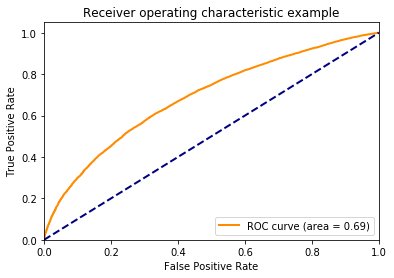

In [44]:
import matplotlib.pyplot as plt
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Naive Bayes

In [55]:
fpr, tpr, thresholds = roc_curve(Y_test['good_bad'].values, skl_gnb.predict_proba(X_test.values)[:, 1]) 
auc = auc(fpr, tpr)

In [56]:
np.asscalar(np.mean(fpr))

0.4780589503050115

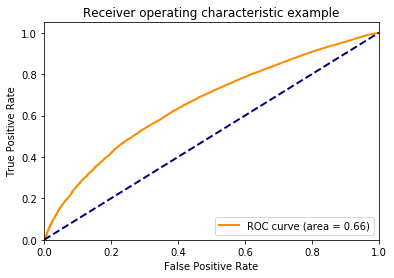

In [57]:
import matplotlib.pyplot as plt
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Decision Tree

In [67]:
fpr, tpr, thresholds = roc_curve(Y_test['good_bad'].values, skl_dt.predict_proba(X_test.values)[:, 1]) 
auc = auc(fpr, tpr)

In [60]:
np.asscalar(np.mean(fpr))

0.4780589503050115

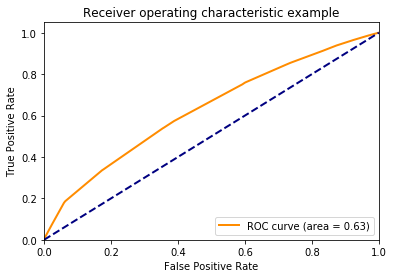

In [68]:
import matplotlib.pyplot as plt
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()